In [9]:
!source venv/bin/activate
%pip install pandas matplotlib

zsh:source:1: no such file or directory: venv/bin/activate
You should consider upgrading via the '/home/phi/side_projects/blockchain/V3_Metrics/FLAIR/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from typing import List, Dict

root_directory = os.getcwd()

In [11]:
def get_pool_flair(address: str):
    dataframes: List[pd.DataFrame] = []
    csv_files = glob.glob(f"../csv/flair/{address}/*.csv")
    csv_files.sort()

    sub_columns = ['flair', 'totalFee0', 'totalFee1', 'poolFee0', 'poolFee1']

    for csv_file in csv_files:
        if "combined.csv" in csv_file:
            continue
        this_df = pd.read_csv(csv_file)
        if len(dataframes) > 0:
            previous_df = dataframes[-1]
            last_row = previous_df.tail(1)[sub_columns]
            this_df[sub_columns] = this_df[sub_columns].add(last_row.values.flatten(), axis=1)
        dataframes.append(this_df)

    if len(dataframes) > 0:
        return pd.concat(dataframes, axis=0, ignore_index=True)

def get_bench_flairs(address: str, tokenIds: List[int]):
    bench_dataframes = {}
    for tokenId in tokenIds:
        token_df = get_pool_flair(f"bench/{address}/{tokenId}")
        bench_dataframes[tokenId] = token_df

    return bench_dataframes

Pool = pd.read_csv("../csv/PoolData.csv")

In [12]:
LQTY_WETH = "0xd1d5a4c0ea98971894772dcd6d2f1dc71083c44e"
LQTY_WETH_range_df = get_pool_flair(LQTY_WETH)
LQTY_WETH_bench_dfs = get_bench_flairs(LQTY_WETH, [366096, 453456, 506262])


LQTY_WETH_range_df.to_csv(f"../csv/flair/{LQTY_WETH}/combined.csv")
for (key, bench_df) in LQTY_WETH_bench_dfs.items():
    bench_df.to_csv(f"../csv/flair/bench/{LQTY_WETH}/{key}/combined.csv")


LQTY_WETH_Pool = Pool[Pool['poolAddress'] == LQTY_WETH].dropna().sort_values('blockNumber')
LQTY_WETH_Pool['flair'] = LQTY_WETH_Pool.apply(lambda x: (x['feesToken0'] + x['feesToken1'] * x['token0Price']) / (x['TVLToken0'] + x['TVLToken1'] * x['token0Price']), axis=1).cumsum()

LQTY_WETH_dfs = {
    "Range": LQTY_WETH_range_df,
    "Pool": LQTY_WETH_Pool,
    **LQTY_WETH_bench_dfs
}

In [13]:
def plot_flairs(dfs: Dict[str | int, pd.DataFrame], pool_name: str):
    plt.figure(figsize=(9, 6))
    for (key, df) in dfs.items():
        plt.plot(df['blockNumber'], df['flair'], label=key)

    plt.title(f"Comparing FLAIRs {pool_name}")
    plt.legend()
    plt.show()

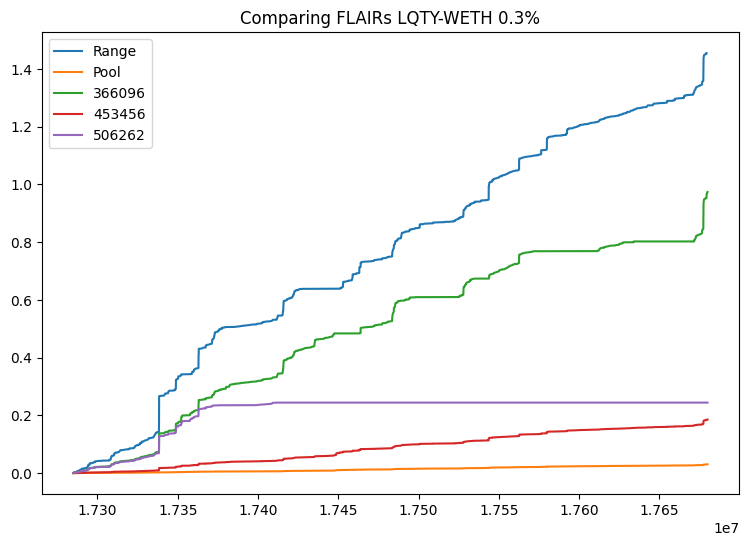

In [14]:
plot_flairs(LQTY_WETH_dfs, "LQTY-WETH 0.3%")

In [15]:
BLOCK_PER_DAY = 7200


def get_daily_FLAIR(df: pd.DataFrame):
    current_day = 17285193
    fee0, fee1 = 0, 0
    fee0_last, fee1_last = 0, 0
    position_values = []
    subset_columns = [
        "totalFee0",
        "totalFee1",
        "poolFee0",
        "poolFee1",
        "blockNumber",
        "positionValueToken0",
        "ETHPrice",
    ]

    daily_df = pd.DataFrame(
        columns=["block", "fee0", "fee1", "positionValue0"], dtype=float
    )

    for _, data in df[subset_columns].iterrows():
        block = int(data["blockNumber"])

        if block > current_day and block < current_day + BLOCK_PER_DAY:
            fee0 = data["totalFee0"]
            fee1 = data["totalFee1"]
            position_values.append(data["positionValueToken0"])

        elif block >= current_day + BLOCK_PER_DAY:
            if len(position_values) > 0:
                fee0_daily = fee0 - fee0_last
                fee1_daily = fee1 - fee1_last
                dailyAvgPositionValue = sum(position_values) / len(
                    position_values
                )  # simple sum
                daily_df.loc[len(daily_df)] = {
                    "block": current_day,
                    "fee0": fee0_daily,
                    "fee1": fee1_daily,
                    "positionValue0": dailyAvgPositionValue,
                }
                fee0_last = fee0
                fee1_last = fee1
                position_values = []
            else:
                daily_df.loc[len(daily_df)] = {
                    "block": current_day,
                    "fee0": 0,
                    "fee1": 0,
                    "positionValue0": np.Infinity,
                }

            current_day += BLOCK_PER_DAY

    return daily_df


def get_pool_daily_flair(pool_df: pd.DataFrame):
    daily_df = pd.DataFrame(
        columns=["block", "fee0", "fee1", "positionValue0"], dtype=float
    )

    current_day = 17285193
    fee0, fee1 = 0, 0
    fee0_last, fee1_last = 0, 0
    position_values = []
    subset_columns = [
        "feesToken0",
        "feesToken1",
        "blockNumber",
        "token0Price",
        "TVLToken0",
        "TVLToken1",
    ]

    for _, data in pool_df[subset_columns].iterrows():
        block = int(data["blockNumber"])

        if block > current_day and block < current_day + BLOCK_PER_DAY:
            fee0 += data["feesToken0"]
            fee1 += data["feesToken1"]
            position_values.append(
                data["TVLToken0"] + data["TVLToken1"] * data["token0Price"]
            )

        elif block >= current_day + BLOCK_PER_DAY:
            if len(position_values) > 0:
                fee0_daily = fee0 - fee0_last
                fee1_daily = fee1 - fee1_last
                fee0_last = fee0
                fee1_last = fee1

                dailyAvgPositionValue = sum(position_values) / len(
                    position_values
                )  # simple sum
                daily_df.loc[len(daily_df)] = {
                    "block": current_day,
                    "fee0": fee0_daily,
                    "fee1": fee1_daily,
                    "positionValue0": dailyAvgPositionValue,
                }
                position_values = []
            else:
                daily_df.loc[len(daily_df)] = {
                    "block": current_day,
                    "fee0": 0,
                    "fee1": 0,
                    "positionValue0": np.Infinity,
                }

            current_day += BLOCK_PER_DAY

    return daily_df

In [38]:
def read_lvr(pool: str, key: str):
    return pd.read_csv(f"../csv/LVR/{pool}/{key}.csv")[
        [
            "open_time",
            "block",
            "token0_usd",
            "token1_usd",
            "daily_LVR",
            "daily_LVR_ratio",
        ]
    ]


def get_PLAIR(flair: pd.DataFrame, lvr: pd.DataFrame):
    daily_flair = get_daily_FLAIR(flair)
    plair = pd.merge(daily_flair, lvr, on="block", how="inner").fillna(method="ffill")
    plair["abs_profit"] = plair.apply(
        lambda x: x["fee0"] * x["token0_usd"]
        + x["fee1"] * x["token1_usd"]
        - x["daily_LVR"] * x["token0_usd"],
        axis=1,
    )
    plair["plair"] = plair.apply(
        lambda x: x["abs_profit"] / (x["positionValue0"] * x["token0_usd"]), axis=1
    ).cumsum()
    return plair


def get_PLAIR_dfs(pool: str, flair_dfs: Dict):
    plair_dfs = {}
    for key, df in flair_dfs.items():
        # NOTE: quick update to include whole pool metrics
        if key == "Pool":
            pool_daily_flair = get_pool_daily_flair(df)
            pool_daily_lvr = pd.read_csv(f"../csv/LVR/{pool}/Range.csv")[
                [
                    "daily_LVR_ratio_full",
                    "daily_LVR_full_USD",
                    "open_time",
                    "block",
                    "token0_usd",
                    "token1_usd",
                ]
            ]
            pool_daily_lvr.rename(columns={"daily_LVR_ratio_full": "daily_LVR_ratio"}, inplace=True)
            plair = pd.merge(
                pool_daily_flair, pool_daily_lvr, on="block", how="inner"
            ).fillna(method="ffill")
            plair["abs_profit"] = plair.apply(
                lambda x: x["fee0"] * x["token0_usd"]
                + x["fee1"] * x["token1_usd"]
                - x["daily_LVR_full_USD"],
                axis=1,
            )
            plair["plair"] = plair.apply(
                lambda x: x["abs_profit"] / (x["positionValue0"] * x["token0_usd"]),
                axis=1,
            ).cumsum()

            plair_dfs["Pool"] = plair
            pass
        else:
            lvr = read_lvr(pool, key)
            plair_dfs[key] = get_PLAIR(df, lvr)

    return plair_dfs

In [39]:
def plot_lvrs(dfs: Dict[str| int, pd.DataFrame], pool_name: str):
    plt.figure(figsize=(15, 6))
    dates = dfs['Range']['open_time']
    for (key, df) in dfs.items():
        plt.plot(dates, df['daily_LVR_ratio'].cumsum(), label=key)
    plt.title(f"Cumulative LVR ratio (LVR / PositionValue) {pool_name}")
    plt.xticks(dates[::4], rotation=45, ha='right')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.show()
    pass

def plot_plairs(dfs: Dict[str | int, pd.DataFrame], pool_name: str):
    plt.figure(figsize=(15, 6))
    dates = dfs['Range']['open_time']
    for (key, df) in dfs.items():
        plt.plot(dates, df['plair'], label=key)

    plt.title(f"Cumulative (Fee-LVR) / PositionValue {pool_name}")
    plt.xticks(dates[::4], rotation=45, ha='right')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.show()


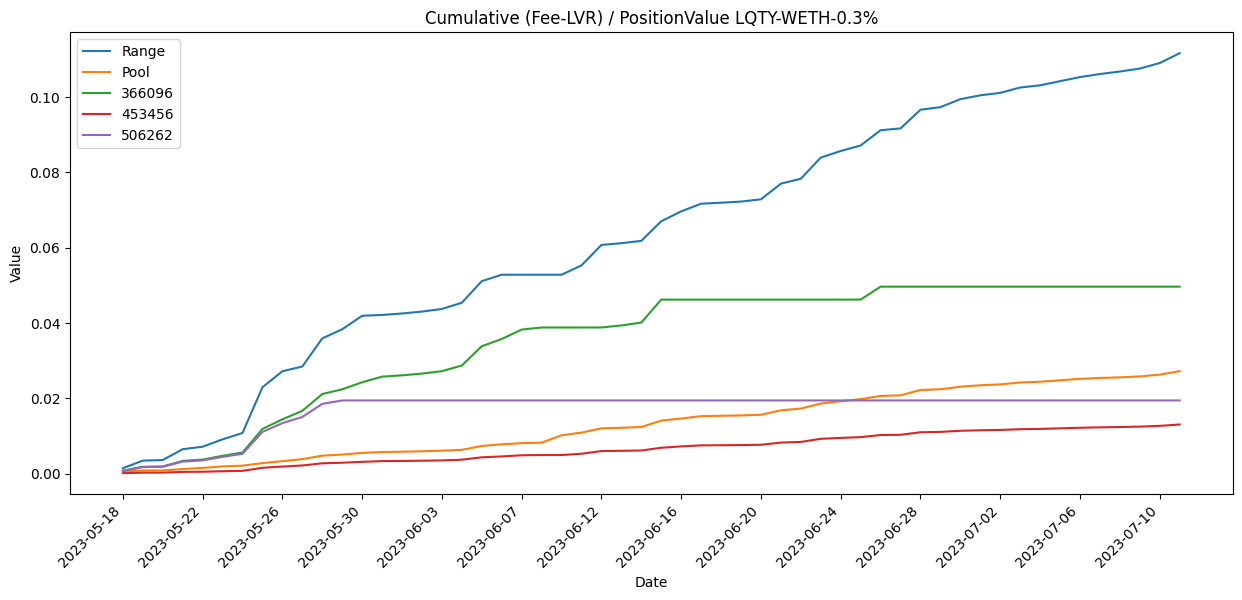

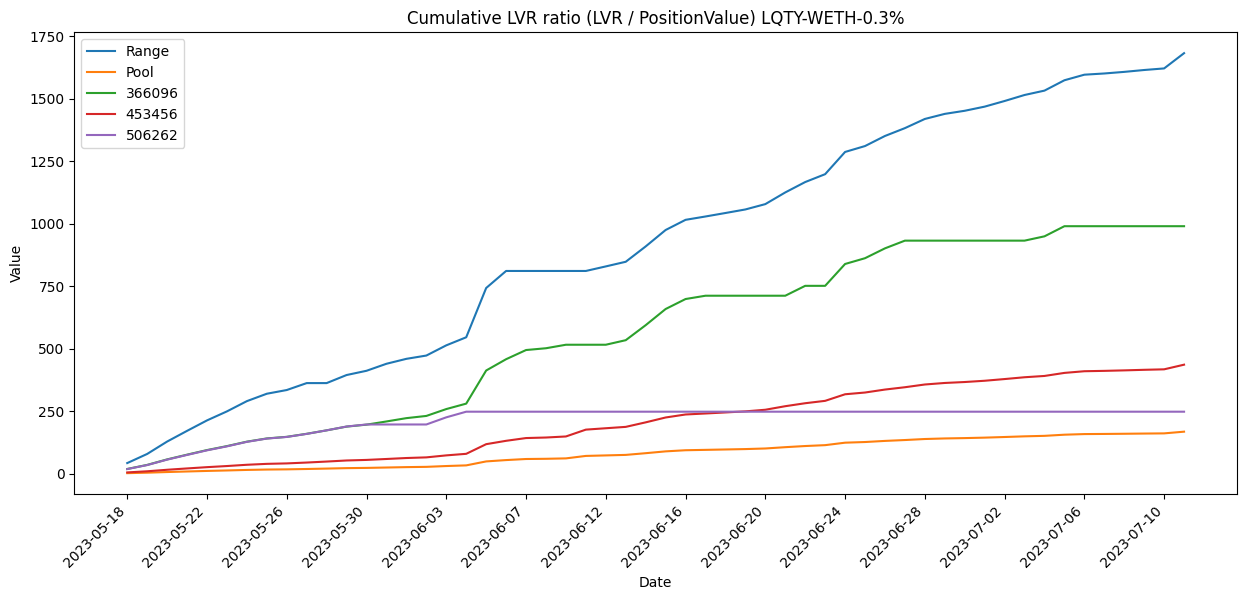

In [40]:
LQTY_WETH_plair_dfs = get_PLAIR_dfs(LQTY_WETH, LQTY_WETH_dfs)

plot_plairs(LQTY_WETH_plair_dfs, "LQTY-WETH-0.3%")
plot_lvrs(LQTY_WETH_plair_dfs, "LQTY-WETH-0.3%")


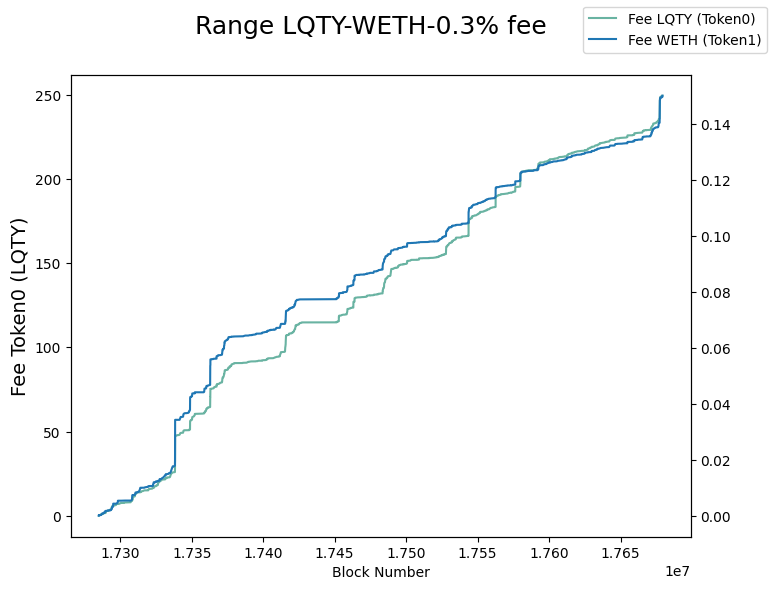

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

ax1.set_xlabel("Block Number")

l1 = ax1.plot(LQTY_WETH_range_df['blockNumber'], LQTY_WETH_range_df['totalFee0'], color="#69b3a2")
ax1.set_ylabel("Fee Token0 (LQTY)", fontsize=14)

l2 = ax2.plot(LQTY_WETH_range_df['blockNumber'], LQTY_WETH_range_df['totalFee1'])

fig.suptitle("Range LQTY-WETH-0.3% fee", fontsize=18)
fig.legend(["Fee LQTY (Token0)", "Fee WETH (Token1)"])

In [ ]:
USDC_WETH = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
USDC_WETH_range_df = get_pool_flair(USDC_WETH)
USDC_WETH_bench_dfs = get_bench_flairs(USDC_WETH, [515539])

USDC_WETH_range_df.to_csv(f"../csv/flair/{USDC_WETH}/combined.csv")
for (key, bench_df) in USDC_WETH_bench_dfs.items():
    bench_df.to_csv(f"../csv/flair/bench/{USDC_WETH}/{key}/combined.csv")

USDC_WETH_Pool = Pool[Pool['poolAddress'] == USDC_WETH].dropna().sort_values('blockNumber')
USDC_WETH_Pool['flair'] = USDC_WETH_Pool.apply(lambda x: (x['feesToken0'] + x['feesToken1'] * x['token0Price']) / (x['TVLToken0'] + x['TVLToken1'] * x['token0Price']), axis=1).cumsum()

USDC_WETH_dfs = {
    "Range": USDC_WETH_range_df,
    "Pool": USDC_WETH_Pool,
    **USDC_WETH_bench_dfs
}

plot_flairs(USDC_WETH_dfs, "USDC-WETH 0.05%")